# Code Flow
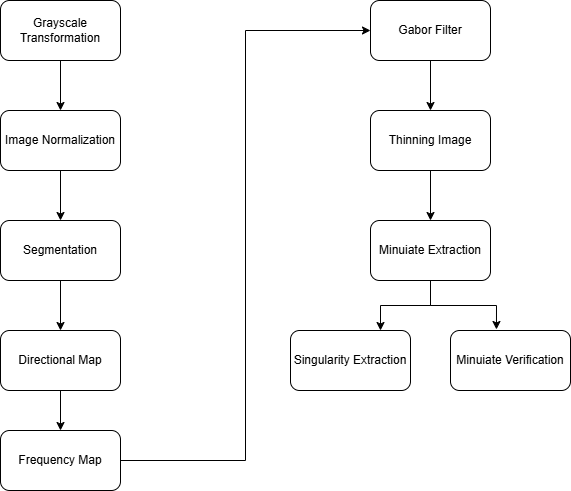

# Preprocessing

In [81]:
import cv2 as cv
from glob import glob
import os
import numpy as np
from utils.poincare import calculate_singularities
from utils.segmentation import create_segmented_and_variance_images
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils import orientation
from utils.crossing_number import calculate_minutiaes
from tqdm import tqdm
from utils.skeletonize import skeletonize
import matplotlib.pyplot as plt
import numpy as np
from utils.crossing_number import *

In [47]:
# Define constants
DATASET_PATH = '../dataset/'
OUT_IMG_PATH = '../processed_img/'
BLOCK_SIZE = 16

def show_img(original_img, processed_img, title="Image"):
    processed_img = cv.cvtColor(processed_img.copy(), cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [69]:
img_name = input("Enter the image name: ")
test_img = cv.imread('../dataset/DB2_B/' + img_name, 0)

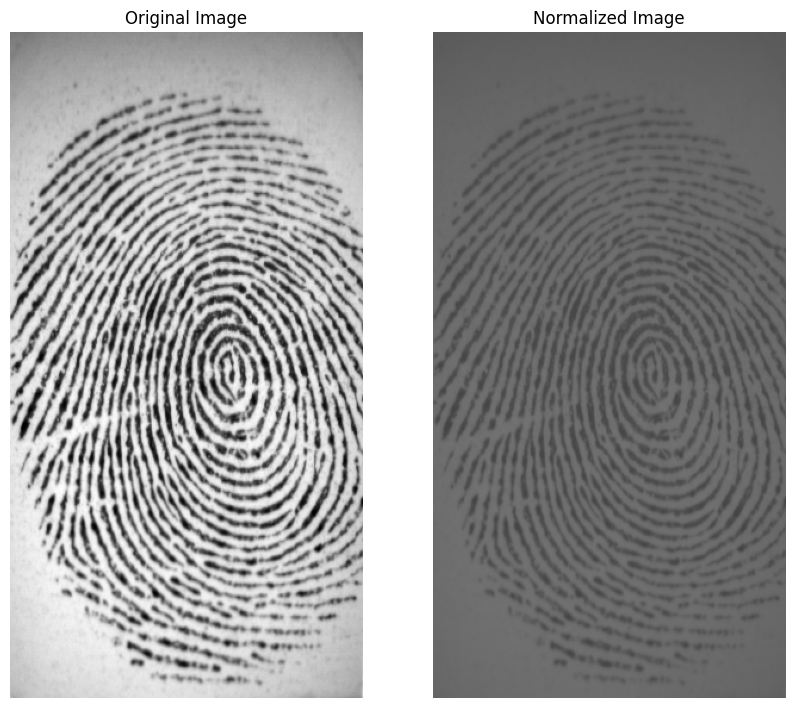

In [48]:

# Normalization - removes the effects of sensor noise and finger pressure differences.
normalized_img = normalize(test_img.copy(), float(100), float(100))
show_img(test_img, normalized_img, "Normalized Image")

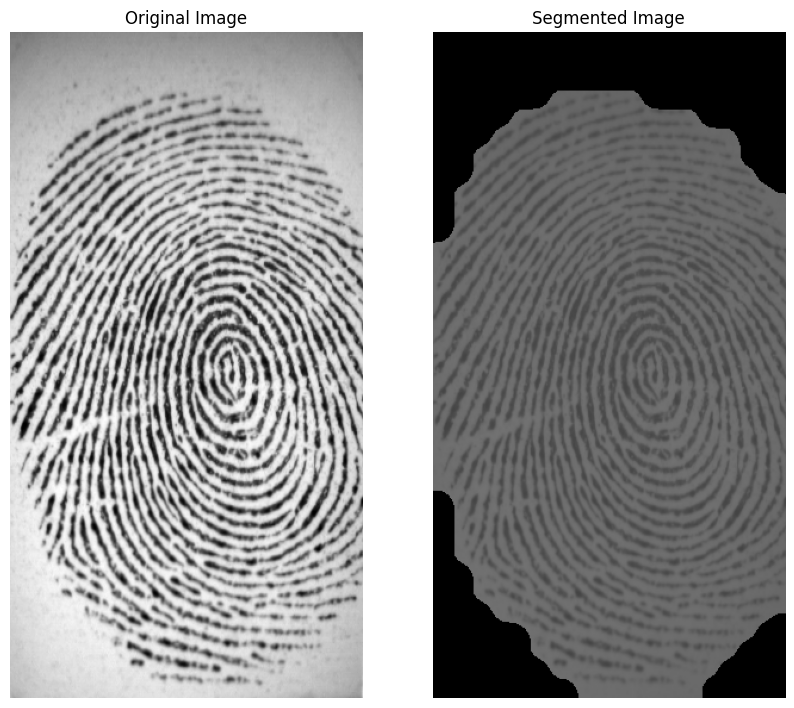

In [49]:
# ROI and normalisation
(segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, BLOCK_SIZE, 0.2)

show_img(test_img, segmented_img, "Segmented Image")

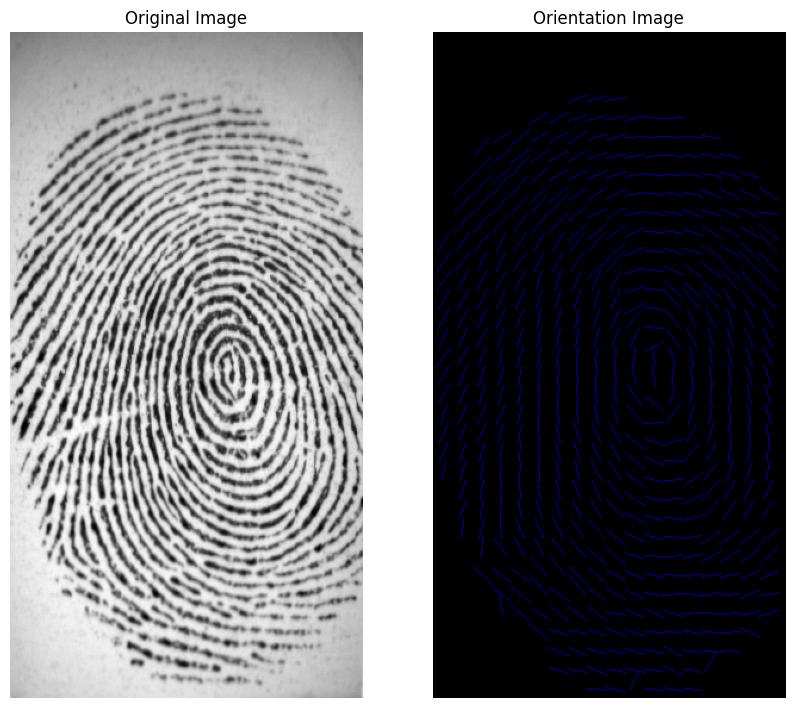

In [50]:
# Orientations
angles = orientation.calculate_angles(normalized_img, W=BLOCK_SIZE, smoth=False)
orientation_img = orientation.visualize_angles(segmented_img, mask, angles, W=BLOCK_SIZE)

show_img(test_img, orientation_img, "Orientation Image")

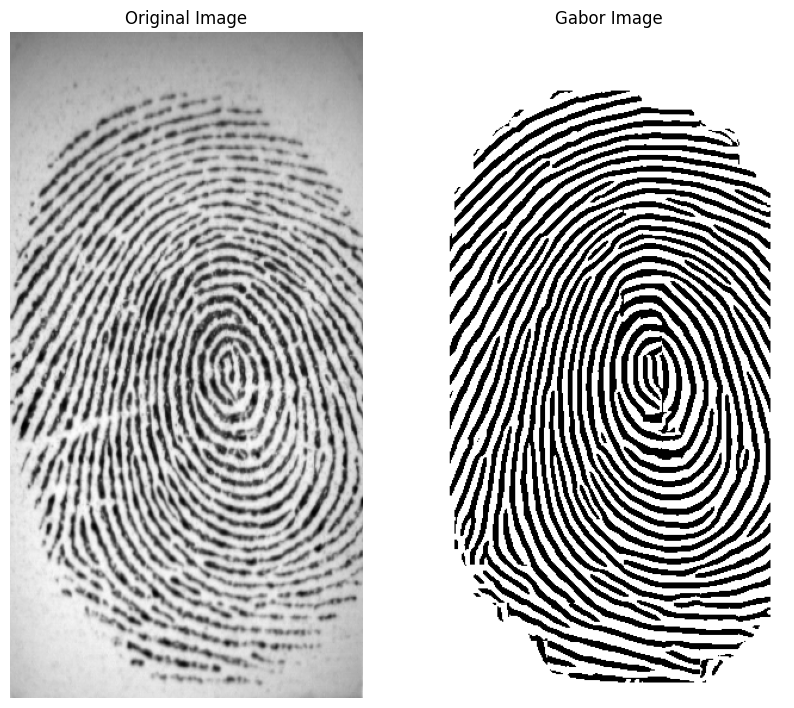

In [51]:
# Find the overall frequency of ridges in Wavelet Domain
freq = ridge_freq(normim, mask, angles, BLOCK_SIZE, kernel_size=5, minWaveLength=5, maxWaveLength=15)

# Create gabor filter and do the actual filtering
gabor_img = gabor_filter(normim, angles, freq)

show_img(test_img, gabor_img, "Gabor Image")

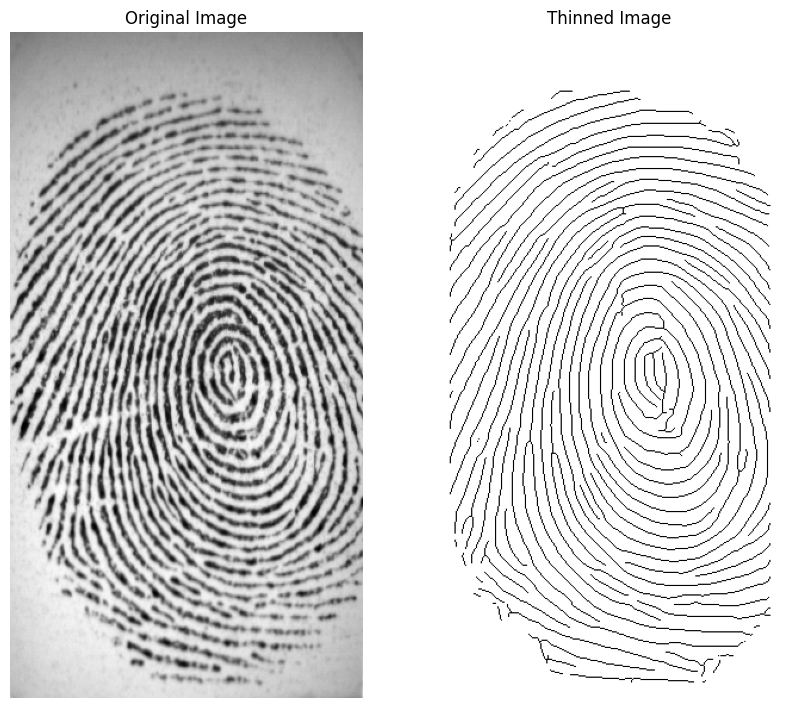

In [52]:
# Thinning oor skeletonize
thin_image = skeletonize(gabor_img)

show_img(test_img, thin_image, "Thinned Image")

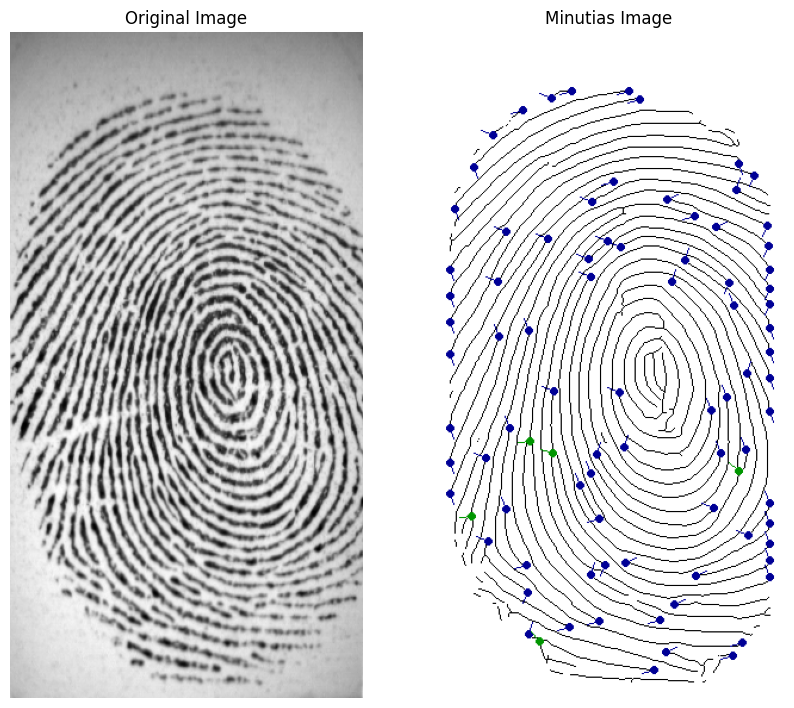

In [64]:
# Minutias
minutias = calculate_minutiaes(thin_image, kernel_size=3)

show_img(test_img, minutias, "Minutias Image")

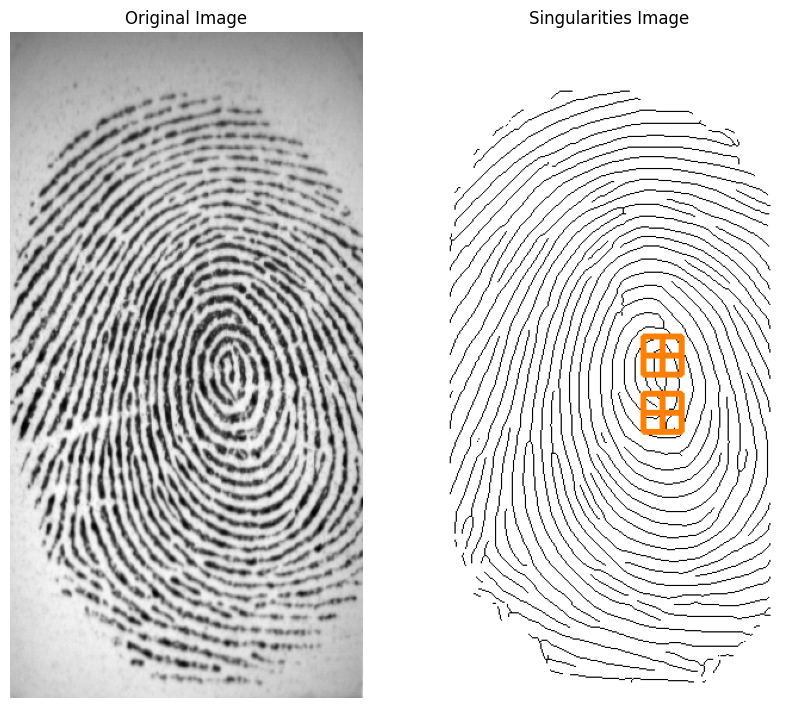

In [65]:
# Singularities
singularities_img = calculate_singularities(thin_image, angles, 1, BLOCK_SIZE, mask)

show_img(test_img, singularities_img, "Singularities Image")

In [67]:
filtered_img = calculate_minutiaes(thin_image, kernel_size=3, filter=True)

show_img(minutias, filtered_img, "Filtered Minutias Image")

TypeError: calculate_minutiaes() got an unexpected keyword argument 'filter'

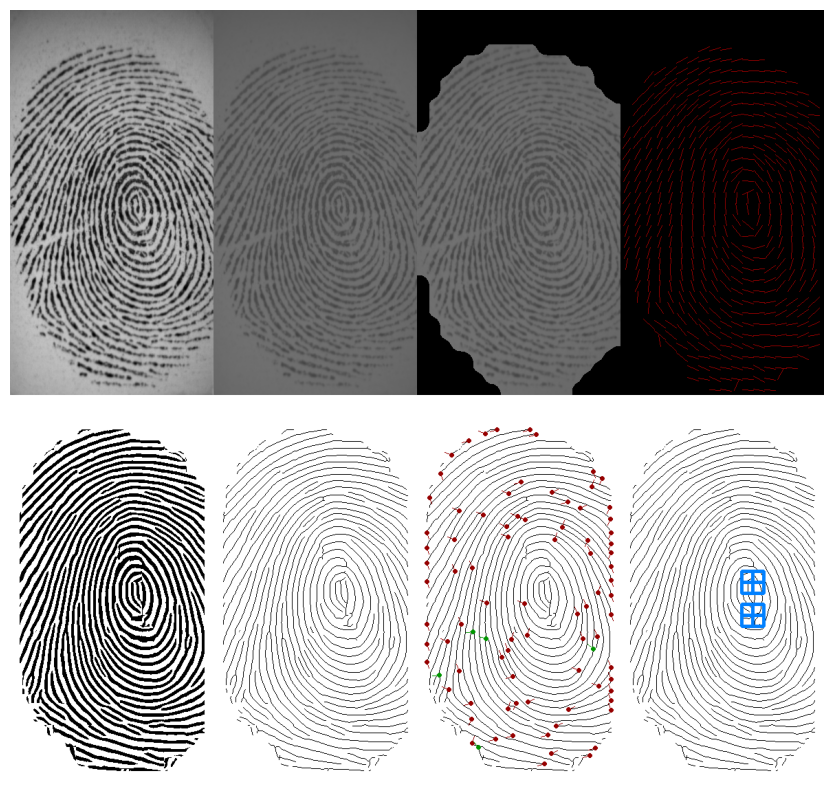

In [68]:
output_imgs = [test_img, normalized_img, segmented_img, orientation_img, gabor_img, thin_image, minutias, singularities_img]
for i in range(len(output_imgs)):
    if len(output_imgs[i].shape) == 2:
        output_imgs[i] = cv.cvtColor(output_imgs[i], cv.COLOR_GRAY2RGB)
results = np.concatenate([np.concatenate(output_imgs[:4], 1), np.concatenate(output_imgs[4:], 1)]).astype(np.uint8)

plt.figure(figsize=(20, 10))
plt.imshow(results)
plt.axis('off')
plt.show()

In [ ]:
# 